In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from scipy import optimize
import re
import copy
import logging
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
sns.set()

# a little hacky, but works if you don't want to actually install the
# custom packages 
sys.path.append('../')
from uniswapv3_simulator.pool import Uniswapv3Pool
from uniswapv3_simulator.utils import *
from uniswapv3_simulator.math import tick_to_sqrt_price, sqrt_price_to_tick
from utils import amount_to_float

In [2]:
POOL = 'DAI-WETH-3000'
NUMERAIRE_TOKEN = 0
MAX_DATE = '2022-01-28'
SAVE_FREQ = 'D'  # change to 'H' if you want hourly pool snapshots
SAVED_POOLS = f'./saved-pools/{POOL}.pickle'
SAVED_DAILY_RETURNS = f'./saved-daily-returns/{POOL}.pickle'
SAVED_WEEKLY_RETURNS = f'./saved-weekly-returns/{POOL}.pickle'

timestamp = datetime.now().strftime('%y%m%d%H%M%S')
logging.basicConfig(level=logging.INFO,
                    filename=f'./logs/{POOL}_{timestamp}.log')
logging.getLogger('uniswap-v3').setLevel(logging.INFO)
logging.getLogger('uniswap-v3.utils').setLevel(logging.DEBUG)

In [3]:
data = pd.read_pickle('../data/pool_data_clean.pickle')
swaps = data[POOL]['swaps']
liquidity = data[POOL]['liquidity']

In [4]:
swaps.info()
swaps.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85084 entries, 0 to 85083
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   swap_time                       85084 non-null  datetime64[ns, UTC]
 1   tx_hash                         85084 non-null  string             
 2   token_0_amount                  85084 non-null  float64            
 3   token_1_amount                  85084 non-null  float64            
 4   pool_address                    85084 non-null  string             
 5   price_tick                      85084 non-null  int64              
 6   price_tick_adjusted             85084 non-null  float64            
 7   contract_address_token_0        85084 non-null  string             
 8   contract_name_token_0           85084 non-null  string             
 9   contract_ticker_symbol_token_0  85084 non-null  string             
 10  contract_d

,swap_time,tx_hash,token_0_amount,token_1_amount,pool_address,price_tick,price_tick_adjusted,contract_address_token_0,contract_name_token_0,contract_ticker_symbol_token_0,contract_decimals_token_0,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,pool_fee,pool_tick_spacing,pool_deploy_time
0,2022-01-29 19:40:04+00:00,0x1ad44b6363d4366ed280163f9bfc5db3144eb779e402...,49993.587664,-19.212778,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,-78625,0.000385,0x6b175474e89094c44da98b954eedeac495271d0f,Dai Stablecoin,DAI,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,3000,60,2021-05-04 20:16:08+00:00
1,2022-01-29 19:38:25+00:00,0x89db0a6e6f070f4ac71cb9ee05f9d53685d656d0da5f...,6498.011618,-2.500000,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,-78605,0.000386,0x6b175474e89094c44da98b954eedeac495271d0f,Dai Stablecoin,DAI,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,3000,60,2021-05-04 20:16:08+00:00
2,2022-01-29 19:35:24+00:00,0x8400651adba9ebf8fe080a2e459d8b6a5597b91b2ee1...,724.898482,-0.278932,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,-78603,0.000386,0x6b175474e89094c44da98b954eedeac495271d0f,Dai Stablecoin,DAI,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,3000,60,2021-05-04 20:16:08+00:00
3,2022-01-29 19:12:54+00:00,0xe9cbde726b3aa82b04516d2116417c5945d81eff9c2d...,6015.972726,-2.315181,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,-78602,0.000386,0x6b175474e89094c44da98b954eedeac495271d0f,Dai Stablecoin,DAI,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,3000,60,2021-05-04 20:16:08+00:00
4,2022-01-29 19:03:47+00:00,0x6ae2345dd7f07c0901adab01a171cbf0edf8167d211e...,-8050.339052,3.116631,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,-78600,0.000386,0x6b175474e89094c44da98b954eedeac495271d0f,Dai Stablecoin,DAI,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,3000,60,2021-05-04 20:16:08+00:00


In [5]:
liquidity.info()
liquidity.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10955 entries, 0 to 10954
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   txn_time                        10955 non-null  datetime64[ns, UTC]
 1   tx_hash                         10955 non-null  string             
 2   token_0_amount                  10955 non-null  float64            
 3   token_1_amount                  10955 non-null  float64            
 4   pool_address                    10955 non-null  string             
 5   liquidity_event                 10955 non-null  string             
 6   price_tick_lower                10955 non-null  int64              
 7   price_tick_upper                10955 non-null  int64              
 8   price_tick_lower_adjusted       10955 non-null  float64            
 9   price_tick_upper_adjusted       10955 non-null  float64            
 10  contract_a

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,account_address,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2022-01-29 12:54:26+00:00,0xa2be14e74e960348d0bb66f8b83c16bddc63492fc718...,0.000000,0.000000,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,REMOVE_LIQUIDITY,-103500,-59940,0.000032,0.002494,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0x4f01339b3094365f857543721740c7e8fd2ace81,3000,60,2021-05-04 20:16:08+00:00,-0.000000
1,2022-01-29 12:49:59+00:00,0x171f4c3cc3f60d25816ea96c3a9927826ab99aab2080...,2465.286500,0.746695,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,ADD_LIQUIDITY,-88740,-64260,0.000140,0.001619,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0xc532e8d1aba3ca8daea0f303b443d36b10bf47d4,3000,60,2021-05-04 20:16:08+00:00,95.047115
2,2022-01-29 12:46:27+00:00,0x5d5916f2d540c0a9294c70bc513e56cb9f0792edb475...,0.000000,0.000000,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,REMOVE_LIQUIDITY,-88740,-64260,0.000140,0.001619,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0xc532e8d1aba3ca8daea0f303b443d36b10bf47d4,3000,60,2021-05-04 20:16:08+00:00,-0.000000
3,2022-01-29 11:08:31+00:00,0x14bd7b351ebd3d669447208c0f48163fe8cdb4121113...,1485.220949,1.481797,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,REMOVE_LIQUIDITY,-91080,-74340,0.000111,0.000591,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0x2746049faca559dbb8619993eb7901d7b0a6df05,3000,60,2021-05-04 20:16:08+00:00,-159.426885
4,2022-01-29 11:08:31+00:00,0x14bd7b351ebd3d669447208c0f48163fe8cdb4121113...,0.000000,2.697595,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,REMOVE_LIQUIDITY,-91080,-79620,0.000111,0.000349,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0x2746049faca559dbb8619993eb7901d7b0a6df05,3000,60,2021-05-04 20:16:08+00:00,-331.267120


In [6]:
adds = liquidity.loc[liquidity['liquidity_event'] == 'ADD_LIQUIDITY', :].copy()
adds = adds.sort_values('txn_time').reset_index(drop=True)
adds.head()

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,account_address,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2021-05-04 20:16:08+00:00,0x8c2161cdf81dacef87759fa8f1f8f94dc9de293b7579...,680.071584,0.175315,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,ADD_LIQUIDITY,-84120,-78240,0.000222,0.000400,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0x3b8ccaa89fcd432f1334d35b10ff8547001ce3e5,3000,60,2021-05-04 20:16:08+00:00,80.059851
1,2021-05-04 20:46:44+00:00,0x963415802ca1d744d6d69ef10f1f5b7080db069a92ce...,335.885061,0.096306,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,ADD_LIQUIDITY,-84120,-78240,0.000222,0.000400,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0xd83eeacb5b03129bc96c8e264063b3e4ad32a544,3000,60,2021-05-04 20:16:08+00:00,41.612787
2,2021-05-04 20:47:12+00:00,0x4916ff106f455203c14b875266c4c91f8f51253976d5...,339.657067,0.056960,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,ADD_LIQUIDITY,-81900,-80040,0.000278,0.000334,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0x0459b3fbf7c1840ee03a63ca4aa95de48322322e,3000,60,2021-05-04 20:16:08+00:00,100.961002
3,2021-05-04 20:50:31+00:00,0xb63423c77e18872cf1ce02fe4cdeee45c652c05ab462...,33.000000,0.009858,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,ADD_LIQUIDITY,-82920,-79560,0.000251,0.000351,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0xc148480a8eff5e6885ab0ac7905291dd11fd6499,3000,60,2021-05-04 20:16:08+00:00,7.079623
4,2021-05-04 21:38:37+00:00,0xc6948b019bbb045db6ab5e4869e63a192686a636451a...,68.356153,0.008000,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,ADD_LIQUIDITY,-85200,-69060,0.000200,0.001002,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0xdd0d6c26a03d6f6541471d44179f56d478f50f6b,3000,60,2021-05-04 20:16:08+00:00,2.582287


In [7]:
first_add_hash = adds.at[0, 'tx_hash']
print(f'First liquidity add hash: {first_add_hash}')

First liquidity add hash: 0x8c2161cdf81dacef87759fa8f1f8f94dc9de293b757939fcf0fdc866e80ed052


In [8]:
# from https://etherscan.io/tx/0xf803bec9942ee16a73f4f5fc861eb642f4f88a98e72b9dbcfc2a1613bbf282d9#eventlog
liquidity_delta = amount_to_float('80059851033970806503', 18)  # belive all liquidity amounts use 18 decimals
assert liquidity_delta == adds.at[0, 'liquidity']

token0 = adds.at[0, 'token_0_amount']
token1 = adds.at[0, 'token_1_amount']
tick_lower = adds.at[0, 'price_tick_lower']
tick_upper = adds.at[0, 'price_tick_upper']
token0_decimals = adds.at[0, 'contract_decimals_token_0']
token1_decimals = adds.at[0, 'contract_decimals_token_1']

init_price = pool_init_price(token0, token1, tick_upper, tick_lower, liquidity_delta,
                             token0_decimals, token1_decimals)

token0_symb = liquidity.at[0, 'contract_ticker_symbol_token_0']
token1_symb = liquidity.at[0, 'contract_ticker_symbol_token_1']
print(f'Pool initial price ({token1_symb}/{token0_symb}): {init_price:,.12e}')
print(f'Pool initial price ({token0_symb}/{token1_symb}): {1 / init_price:,.12e}')

Pool initial price (WETH/DAI): 2.923692113061e-04
Pool initial price (DAI/WETH): 3.420332789259e+03


In [9]:
sqrt_price_x96 = 1354707084081889255546596745
etherscan_price = sqrt_price_x96 ** 2 / 2 ** 192
print(f"Calculated initial price: {init_price:.12e}")
print(f"Price per Etherscan:      {etherscan_price:.12e}")

Calculated initial price: 2.923692113061e-04
Price per Etherscan:      2.923692113059e-04


In [10]:
all_txn = organize_txns(liquidity, swaps, max_date=MAX_DATE)
all_txn

,orig_idx,tx_hash,txn_time,event
0,10954,0x8c2161cdf81dacef87759fa8f1f8f94dc9de293b7579...,2021-05-04 20:16:08+00:00,ADD_LIQUIDITY
1,85083,0x2bdb4298b35adf058a38dfbe85470f67da1cb76e1694...,2021-05-04 20:21:15+00:00,SWAP
2,10953,0x963415802ca1d744d6d69ef10f1f5b7080db069a92ce...,2021-05-04 20:46:44+00:00,ADD_LIQUIDITY
3,10952,0x4916ff106f455203c14b875266c4c91f8f51253976d5...,2021-05-04 20:47:12+00:00,ADD_LIQUIDITY
4,10951,0xb63423c77e18872cf1ce02fe4cdeee45c652c05ab462...,2021-05-04 20:50:31+00:00,ADD_LIQUIDITY
...,...,...,...,...
95656,360,0xeaf0faccfaa24981e885849cda5e59abfb31148b5b6e...,2022-01-27 23:43:05+00:00,SWAP
95657,359,0x2ab192bdddbddadfad0799bc610795145c583ff579c8...,2022-01-27 23:44:12+00:00,SWAP
95658,358,0xf39c37bfbdb1904fc71752417de983d4d6b7fd35a242...,2022-01-27 23:52:44+00:00,SWAP
95659,357,0x8ff7c5ffbd38fb2485b5c81de031c4d3eeafee485232...,2022-01-27 23:52:48+00:00,SWAP


In [11]:
CHECKS_ON = False
# need to think about appropriate error tolerances
# TODO: maybe base these tolerances on the average transaction size?
TOKEN0_TOLS = {'atol': 1e-12, 'rtol': 1e-8}
TOKEN1_TOLS = {'atol': 1e-12, 'rtol': 1e-8}
LIQUIDITY_TOLS = {'atol': 1e-8, 'rtol': 1e-5}

In [ ]:
pool_snapshots, tx_results = run_historical_pool(
    init_price, 
    all_txn, 
    liquidity, 
    swaps,
    save_freq=SAVE_FREQ,
    position_id='generic_LP', 
    checks_on=CHECKS_ON, 
    verbose=True,
    token0_tols=TOKEN0_TOLS,
    token1_tols=TOKEN1_TOLS,
    liquidity_tols=LIQUIDITY_TOLS
)
pd.to_pickle(pool_snapshots, SAVED_POOLS)

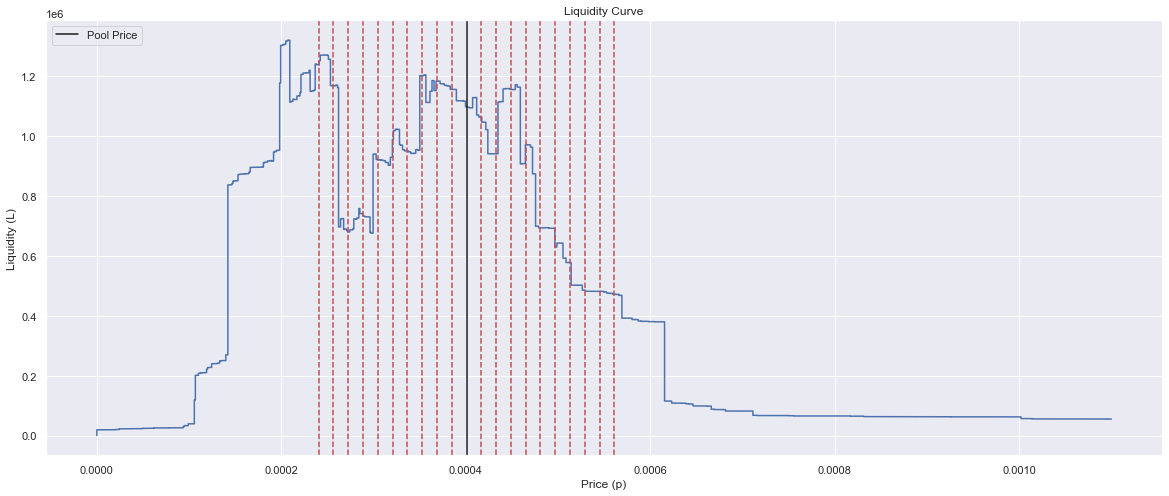

In [13]:
example_day = '2022-01-27 00:00:00'
sigma = 0.04
pool = pool_snapshots[example_day]
price_bins = np.array(
    [0]
    + [pool.price * (1 + i * sigma) for i in range(-10, 11)]
    + [np.inf]
)

fig, ax = plt.subplots(figsize=(20, 8))
pool.plot_liquidity_curve(interval=(0, 0.001), ax=ax)

for price in price_bins[1:-1]:
    if price == pool.price:
        ax.axvline(price, color='k', label='Pool Price')
    else:
        ax.axvline(price, color='r', linestyle='--')
ax.legend(loc='upper left')

plt.show()

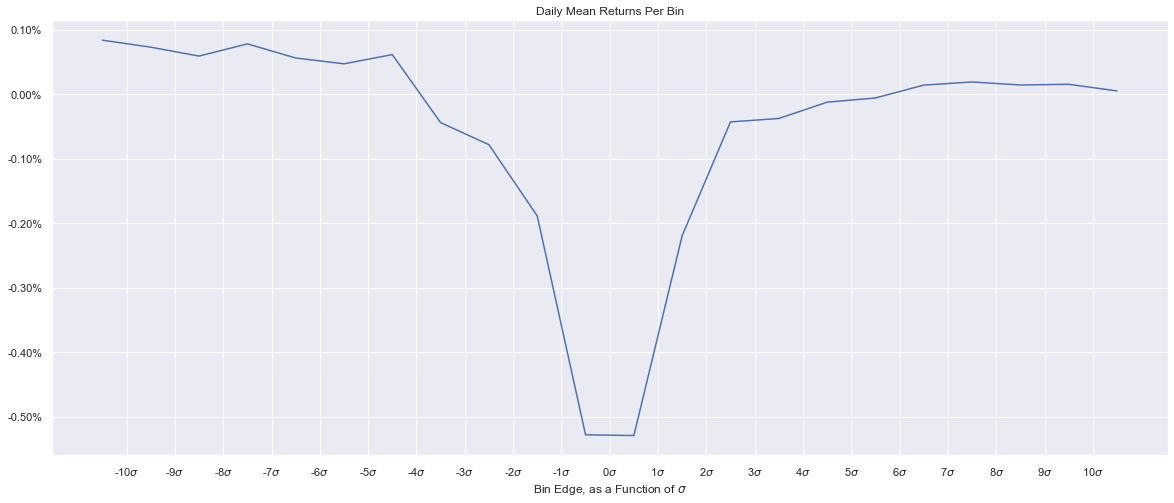

CPU times: user 3min 20s, sys: 4.25 s, total: 3min 24s
Wall time: 3min 27s


In [14]:
%%time
# daily returns
all_returns = calc_all_returns_per_bin(
    pool_snapshots, 
    all_txn, 
    liquidity, 
    swaps,
    freq='D',  # pandas frequency codes (can also include anchor)
    sigma=0.04, 
    numeraire_token=NUMERAIRE_TOKEN
)
pd.to_pickle(all_returns, SAVED_DAILY_RETURNS)
   
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)
        
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Daily Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

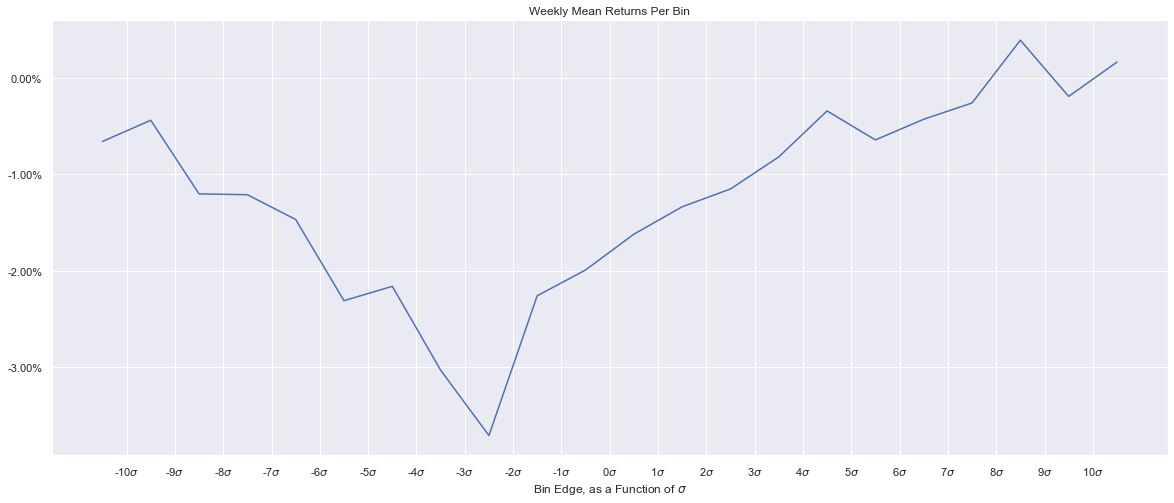

CPU times: user 52.4 s, sys: 1.61 s, total: 54 s
Wall time: 55.1 s


In [15]:
%%time
# weekly returns
all_returns = calc_all_returns_per_bin(
    pool_snapshots, 
    all_txn, 
    liquidity, 
    swaps,
    freq='W',  # pandas frequency codes (can also include anchor)
    sigma=0.04, 
    numeraire_token=NUMERAIRE_TOKEN
)
pd.to_pickle(all_returns, SAVED_WEEKLY_RETURNS)
   
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)
        
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Weekly Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

In [16]:
# %%time
# # hourly returns
# all_returns = calc_all_returns_per_bin(
#     pool_snapshots, 
#     all_txn, 
#     liquidity, 
#     swaps,
#     freq='H',  # pandas frequency codes (can also include anchor)
#     sigma=0.005,  # reducing this for this test
#     numeraire_token=NUMERAIRE_TOKEN
# )
# # pd.to_pickle(all_returns, SAVED_WEEKLY_RETURNS) NOT SAVING THIS ONE FOR NOW!
   
# bin_returns = defaultdict(list)
# for day, irrs in all_returns.items():
#     for bin_pos, irr in irrs.items():
#         bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
#         bin_returns[bin_no].append(irr)
        
# fig, ax = plt.subplots(figsize=(20, 8))

# x_pos, x_labels, y = [], [], []
# for i in range(1, 23):
#     x_pos.append(i)
#     x_labels.append(f'{i - 11}$\sigma$')
#     y.append(np.mean(bin_returns[i]))
# ax.plot(x_pos, y)

# ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
# ax.set_title('Hourly Mean Returns Per Bin')
# ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
# ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

# plt.show()